# Overview
- Read csv with document data in it
- Split into train/test data
- Train model
- Test model

# Initialization

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pdfminer as pdfm

from io import StringIO

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

import nltk
nltk.download("punkt")
from nltk.classify import NaiveBayesClassifier

import string
from collections import Counter

[nltk_data] Downloading package punkt to /Users/emilyng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read the document data

In [185]:
doc_df = pd.read_csv("Data/doc_list1.csv")
doc_df

Unnamed: 0  doc_num                               doc_filepath  \
0             0        0      Data/Environmental/PLAW-104publ70.pdf   
1             1        1     Data/Environmental/PLAW-112publ177.pdf   
2             2        2      Data/Environmental/PLAW-116publ63.pdf   
3             3        3     Data/Environmental/PLAW-110publ288.pdf   
4             4        4     Data/Environmental/PLAW-108publ425.pdf   
..          ...      ...                                        ...   
134         134      134   Data/NonEnvironmental/PLAW-114publ38.pdf   
135         135      135  Data/NonEnvironmental/PLAW-115publ281.pdf   
136         136      136  Data/NonEnvironmental/PLAW-115publ280.pdf   
137         137      137   Data/NonEnvironmental/PLAW-116publ52.pdf   
138         138      138  Data/NonEnvironmental/PLAW-116publ107.pdf   

                                              doc_text  \
0    PUBLIC LAW 104–70—DEC. 23, 1995\n\n109 STAT. 7...   
1    PUBLIC LAW 112–177—SEPT. 28, 2012 \n\n126 STAT...   
2    133 STAT. 1120 \n\nPUBLIC LAW 116–63—OCT. 4, 2...   
3    PUBLIC LAW 110–288—JULY 29, 2008 \n\nCLEAN BOA...   
4    PUBLIC LAW 108–425—NOV. 30, 2004\n\nTIJUANA RI...   
..                                                 ...   
134  PUBLIC LAW 114–38—JULY 28, 2015 \n\n129 STAT. ...   
135  PUBLIC LAW 115–281—DEC. 1, 2018 \n\n132 STAT. ...   
136  132 STAT. 4190 \n\nPUBLIC LAW 115–280—NOV. 29,...   
137  133 STAT. 1076 \n\nPUBLIC LAW 116–52—AUG. 23, ...   
138  133 STAT. 3292 \n\nPUBLIC LAW 116–107—JAN. 17,...   

                                          text_cleaned  \
0    public law dec   stat public law th congressan...   
1    public law sept   stat public law th congressa...   
2     stat public law oct  public law th congressan...   
3    public law july  clean boating act of swalcilb...   
4    public law nov  tijuana river valley estuary a...   
..                                                 ...   
134  public law july   stat public law th congressa...   
135  public law dec   stat public law th congressan...   
136   stat public law nov  public law th congressan...   
137   stat public law aug  public law th congressan...   
138   stat public law jan  public law th congressan...   

                                            nltk_words  \
0    ['public', 'law', 'dec', 'stat', 'public', 'la...   
1    ['public', 'law', 'sept', 'stat', 'public', 'l...   
2    ['stat', 'public', 'law', 'oct', 'public', 'la...   
3    ['public', 'law', 'july', 'clean', 'boating', ...   
4    ['public', 'law', 'nov', 'tijuana', 'river', '...   
..                                                 ...   
134  ['public', 'law', 'july', 'stat', 'public', 'l...   
135  ['public', 'law', 'dec', 'stat', 'public', 'la...   
136  ['stat', 'public', 'law', 'nov', 'public', 'la...   
137  ['stat', 'public', 'law', 'aug', 'public', 'la...   
138  ['stat', 'public', 'law', 'jan', 'public', 'la...   

                                        filtered_words  \
0    ['public', 'law', 'dec', 'stat', 'public', 'la...   
1    ['public', 'law', 'sept', 'stat', 'public', 'l...   
2    ['stat', 'public', 'law', 'oct', 'public', 'la...   
3    ['public', 'law', 'july', 'clean', 'boating', ...   
4    ['public', 'law', 'nov', 'tijuana', 'river', '...   
..                                                 ...   
134  ['public', 'law', 'july', 'stat', 'public', 'l...   
135  ['public', 'law', 'dec', 'stat', 'public', 'la...   
136  ['stat', 'public', 'law', 'nov', 'public', 'la...   
137  ['stat', 'public', 'law', 'aug', 'public', 'la...   
138  ['stat', 'public', 'law', 'jan', 'public', 'la...   

                                           word_counts  \
0    [('may', 4), ('occupancy', 4), ('vehicle', 3),...   
1    [('new', 367), ('application', 239), ('use', 2...   
2    [('water', 19), ('state', 12), ('revolving', 9...   
3    [('management', 14), ('recreational', 12), ('a...   
4    [('may', 9), ('act', 7), ('paragraph', 7), ('l...   
..              

In [186]:
doc_df.shape

(139, 10)

# Split Training vs Testing Data

In [187]:
train_filter = doc_df['doc_num']%2 == 0
test_filter = ~train_filter
#train_filter
#test_filter
training_df = doc_df.loc[train_filter]
testing_df = doc_df.loc[test_filter]

In [188]:
training_df.shape

(70, 10)

In [189]:
testing_df.head()

Unnamed: 0  doc_num                            doc_filepath  \
1           1        1  Data/Environmental/PLAW-112publ177.pdf   
3           3        3  Data/Environmental/PLAW-110publ288.pdf   
5           5        5  Data/Environmental/PLAW-105publ156.pdf   
7           7        7   Data/Environmental/PLAW-116publ62.pdf   
9           9        9  Data/Environmental/PLAW-111publ191.pdf   

                                            doc_text  \
1  PUBLIC LAW 112–177—SEPT. 28, 2012 \n\n126 STAT...   
3  PUBLIC LAW 110–288—JULY 29, 2008 \n\nCLEAN BOA...   
5  (cid:80)(cid:85)(cid:66)(cid:76)(cid:73)(cid:6...   
7  133 STAT. 1118 \n\nPUBLIC LAW 116–62—OCT. 4, 2...   
9  124 STAT. 1278 \n\nPUBLIC LAW 111–191—JUNE 15,...   

                                        text_cleaned  \
1  public law sept   stat public law th congressa...   
3  public law july  clean boating act of swalcilb...   
5  cidcidcidcidcidcidcidcidcidcidcidcidcidcidcidc...   
7   stat public law oct  oct  s alaska remotegene...   
9   stat public law june  public law th congressa...   

                                          nltk_words  \
1  ['public', 'law', 'sept', 'stat', 'public', 'l...   
3  ['public', 'law', 'july', 'clean', 'boating', ...   
5  ['cidcidcidcidcidcidcidcidcidcidcidcidcidcidci...   
7  ['stat', 'public', 'law', 'oct', 'oct', 's', '...   
9  ['stat', 'public', 'law', 'june', 'public', 'l...   

                                      filtered_words  \
1  ['public', 'law', 'sept', 'stat', 'public', 'l...   
3  ['public', 'law', 'july', 'clean', 'boating', ...   
5  ['cidcidcidcidcidcidcidcidcidcidcidcidcidcidci...   
7  ['stat', 'public', 'law', 'oct', 'oct', 'alask...   
9  ['stat', 'public', 'law', 'june', 'public', 'l...   

                                         word_counts  \
1  [('new', 367), ('application', 239), ('use', 2...   
3  [('management', 14), ('recreational', 12), ('a...   
5  [('cidcidcidcid', 173), ('cidcidcid', 173), ('...   
7  [('oct', 5), ('emissions', 4), ('public', 3), ...   
9  [('oil', 7), ('june', 4), ('act', 4), ('advanc...   

                                                 bow      env_label  
1  {'public': 1, 'law': 1, 'sept': 1, 'stat': 1, ...  Environmental  
3  {'public': 1, 'law': 1, 'july': 1, 'clean': 1,...  Environmental  
5  {'cidcidcidcidcidcidcidcidcidcidcidcidcidcidci...  Environmental  
7  {'stat': 1, 'public': 1, 'law': 1, 'oct': 1, '...  Environmental  
9  {'stat': 1, 'public': 1, 'law': 1, 'june': 1, ...  Environmental

In [190]:
training_df.head()

Unnamed: 0  doc_num                            doc_filepath  \
0           0        0   Data/Environmental/PLAW-104publ70.pdf   
2           2        2   Data/Environmental/PLAW-116publ63.pdf   
4           4        4  Data/Environmental/PLAW-108publ425.pdf   
6           6        6  Data/Environmental/PLAW-114publ182.pdf   
8           8        8  Data/Environmental/PLAW-111publ378.pdf   

                                            doc_text  \
0  PUBLIC LAW 104–70—DEC. 23, 1995\n\n109 STAT. 7...   
2  133 STAT. 1120 \n\nPUBLIC LAW 116–63—OCT. 4, 2...   
4  PUBLIC LAW 108–425—NOV. 30, 2004\n\nTIJUANA RI...   
6  PUBLIC LAW 114–182—JUNE 22, 2016 \n\nFRANK R. ...   
8  124 STAT. 4128 \n\nPUBLIC LAW 111–378—JAN. 4, ...   

                                        text_cleaned  \
0  public law dec   stat public law th congressan...   
2   stat public law oct  public law th congressan...   
4  public law nov  tijuana river valley estuary a...   
6  public law june  frank r lautenberg chemical s...   
8   stat public law jan  public law th congressan...   

                                          nltk_words  \
0  ['public', 'law', 'dec', 'stat', 'public', 'la...   
2  ['stat', 'public', 'law', 'oct', 'public', 'la...   
4  ['public', 'law', 'nov', 'tijuana', 'river', '...   
6  ['public', 'law', 'june', 'frank', 'r', 'laute...   
8  ['stat', 'public', 'law', 'jan', 'public', 'la...   

                                      filtered_words  \
0  ['public', 'law', 'dec', 'stat', 'public', 'la...   
2  ['stat', 'public', 'law', 'oct', 'public', 'la...   
4  ['public', 'law', 'nov', 'tijuana', 'river', '...   
6  ['public', 'law', 'june', 'frank', 'lautenberg...   
8  ['stat', 'public', 'law', 'jan', 'public', 'la...   

                                         word_counts  \
0  [('may', 4), ('occupancy', 4), ('vehicle', 3),...   
2  [('water', 19), ('state', 12), ('revolving', 9...   
4  [('may', 9), ('act', 7), ('paragraph', 7), ('l...   
6  [('administrator', 295), ('chemical', 253), ('...   
8  [('stormwater', 6), ('federal', 5), ('jan', 4)...   

                                                 bow      env_label  
0  {'public': 1, 'law': 1, 'dec': 1, 'stat': 1, '...  Environmental  
2  {'stat': 1, 'public': 1, 'law': 1, 'oct': 1, '...  Environmental  
4  {'public': 1, 'law': 1, 'nov': 1, 'tijuana': 1...  Environmental  
6  {'public': 1, 'law': 1, 'june': 1, 'frank': 1,...  Environmental  
8  {'stat': 1, 'public': 1, 'law': 1, 'jan': 1, '...  Environmental

# Train the Model

In [10]:
def create_nb_input(doc_df, label) :
    ctr = 0
    for word_list in doc_df['bow'].tolist() :
#        print(type(word_list))
#        print(word_list)
#        break
        if ctr == 0 :
            nb_input = [(word_list, label)]
        else :
            nb_input.append((word_list, label))
        ctr += 1
    return nb_input

In [11]:
filter = training_df['env_label'] == "Environmental"
env_training_df = training_df.loc[filter]
notenv_training_df = training_df.loc[~filter]

In [12]:
nb_env_input = create_nb_input(env_training_df, 'Environmental')
nb_notenv_input = create_nb_input(notenv_training_df, 'NotEnvironmental')
print(nb_env_input[0][0])

{'public': 1, 'law': 1, '112–177—sept': 1, 'stat': 1, '1327public': 1, '112–177112th': 1, 'congressan': 1, 'actto': 1, 'reauthorize': 1, 'federal': 1, 'insecticide': 1, 'fungicide': 1, 'rodenticide': 1, 'act.be': 1, 'enacted': 1, 'senate': 1, 'house': 1, 'representatives': 1, 'ofthe': 1, 'united': 1, 'states': 1, 'america': 1, 'congress': 1, 'assembled': 1, 'section': 1, '1.': 1, 'short': 1, 'title.this': 1, 'act': 1, 'may': 1, 'cited': 1, 'pesticide': 1, 'registration': 1, 'improve-ment': 1, 'extension': 1, '.sept': 1, 's.': 1, 'pesticideregistrationimprovementextension': 1, 'actof': 1, '2012.7': 1, 'usc': 1, 'note.sec': 1, '2.': 1, 'improvement': 1, 'maintenance': 1, 'fees.—': 1, 'fees.—section': 1, 'u.s.c': 1, '136a–1': 1, 'amended—': 1, 'paragraph': 1, 'subparagraph': 1, 'striking': 1, 'aggregateamount': 1, 'follows': 1, 'end': 1, 'inserting': 1, 'aggregate': 1, 'amount': 1, '27,800,000': 1, 'fiscal': 1, 'years': 1, 'through2017.': 1, 'ii': 1, 'clause': 1, 'shall': 1, 'andall': 1, 

In [13]:
print(type(nb_env_input))
print(len(nb_env_input))

<class 'list'>
12


In [14]:
legislative_subject_classifier = NaiveBayesClassifier.train(nb_env_input[0][0] + nb_notenv_input[0][0])
#legislative_subject_classifier = NaiveBayesClassifier.train(nb_env_input[0][0] + nb_notenv_input[0][0])
#legislative_subject_classifier = NaiveBayesClassifier.train(nb_env_input[0][0] + nb_notenv_input[0][0])

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
nltk.classify.util.accuracy(mr_op_classifier, nb_mr_train_input + nb_op_train_input)*100

# Test the model
- essentially just run the accuracy but pass in the testing data instead of the training data

### Using TFIDF vectorizer

In [615]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
import seaborn as sns

def vectorize(X_text_tr, X_text_val, vectorizer_type):
    '''
    Vectorizes text into machine readable and model ready input format.
    
    Input:
        X_text_tr (Training set texts)
        X_text_val (Validation set texts)
        vectorizer_type ['tfidf', 'counter']
    Output:
        X_tr_vector: sparse matrix; vectorized training text features
        X_val_vector: sparse matrix; vectorized validation text features
        train_df: doc-term term frequencies dataframe (training)
        val_df: 
        vectorizer: vectorizer object; fitted on X_text_tr to be used to transform test text
    '''
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.1, lowercase=True, analyzer='word',
                                 stop_words= 'english',ngram_range=(1,1))
    elif vectorizer_type == 'counter':
        vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.1, lowercase=True, analyzer='word',
                                 stop_words= 'english',ngram_range=(1,1))
        
    X_tr_vector = vectorizer.fit_transform(X_text_tr.ravel())
    X_val_vector = vectorizer.transform(X_text_val.ravel())
    
    feature_names = vectorizer.get_feature_names()
    dense1 = X_tr_vector.todense().tolist()
    dense2 = X_val_vector.todense().tolist()
    train_df = pd.DataFrame(dense1, columns=feature_names)
    val_df = pd.DataFrame(dense2, columns=feature_names)
    
    return X_tr_vector, X_val_vector, train_df, val_df, vectorizer

In [683]:
text = doc_df['text_cleaned']
y = (doc_df['env_label'] == 'Environmental')

#test random_state
text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.2)
text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.2)

kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=25)
#model using TFIDF vectorizer
X_train, X_val, df_train, df_val, vectorizer = vectorize(text_train, text_val, 'tfidf')
X, y = X_train.toarray(), np.array(y_train)

train_accuracies, train_precisions, train_recalls, train_f1s, train_fbetas = [], [], [], [], []
val_accuracies, val_precisions, val_recalls, val_f1s, val_fbetas = [], [], [], [], []

for train_ind, val_ind in kf.split(X,y):
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    model = BernoulliNB()
    model.fit(X_train, y_train)
    ytrain_preds = model.predict(X_train)
    ytrain_preds_probs = model.predict_proba(X_train)[:,1]
    train_preds = np.where(ytrain_preds_probs > 0.5, 1, 0)
    yval_preds = model.predict(X_val)
    yval_preds_probs = model.predict_proba(X_val)[:,1]
    val_trains = np.where(yval_preds_probs > 0.5, 1, 0)
    
#     train_acc = model.score(X_train, y_train)
#     val_acc = model.score(X_val, y_val)
    train_accuracies.append(accuracy_score(y_train, ytrain_preds))
    train_precisions.append(precision_score(y_train, train_preds))
    train_recalls.append(recall_score(y_train, ytrain_preds))
    train_f1s.append(f1_score(y_train, ytrain_preds))   
    train_fbetas.append(fbeta_score(y_train, ytrain_preds, beta=0))

    val_accuracies.append(accuracy_score(y_val, yval_preds))
    val_precisions.append(precision_score(y_val, yval_preds))
    val_recalls.append(recall_score(y_val, yval_preds))
    val_f1s.append(f1_score(y_val, yval_preds))   
    val_fbetas.append(fbeta_score(y_val, yval_preds, beta=0))
    
train_scores = [train_accuracies, train_precisions, train_recalls, train_f1s, train_fbetas]
val_scores = [val_accuracies, val_precisions, val_recalls, val_f1s, val_fbetas]
scores = ['Accuracy', 'Precision', 'Recall', 'F1', 'FBeta']

In [686]:
for score, tr, val in zip(scores, train_scores, val_scores):
    print(score)
    print(f'Train: {np.mean(tr):.3f} +- {np.std(tr):.3f}')
    print(f'Val: {np.mean(val):.3f} +- {np.std(val):.3f}')
    print('-------------')

Accuracy
Train: 0.810 +- 0.048
Val: 0.731 +- 0.112
-------------
Precision
Train: 0.855 +- 0.062
Val: 0.713 +- 0.210
-------------
Recall
Train: 0.609 +- 0.096
Val: 0.540 +- 0.198
-------------
F1
Train: 0.709 +- 0.078
Val: 0.597 +- 0.180
-------------
FBeta
Train: 0.855 +- 0.062
Val: 0.713 +- 0.210
-------------


In [687]:
print('Validation Results')
print(classification_report(y_val, yval_preds))
print('')

Validation Results
              precision    recall  f1-score   support

       False       0.67      0.80      0.73        10
        True       0.60      0.43      0.50         7

    accuracy                           0.65        17
   macro avg       0.63      0.61      0.61        17
weighted avg       0.64      0.65      0.63        17




### Testing Model on Hold-out/Test Set

In [688]:
X_test = vectorizer.transform(text_test)
preds = model.predict(X_test)
print(f'Test Accuracy: ', model.score(X_test, y_test))

Test Accuracy:  0.6428571428571429


<!-- #save model in pickle format
pd.to_pickle(model, 'env_classifier.pkl') -->

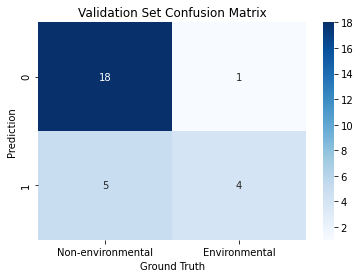

In [661]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Non-environmental', 'Environmental'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction');

In [ ]:
# text = doc_df['text_cleaned']
# y = (doc_df['env_label'] == 'Environmental')

# # text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.2)
# text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.2)

# X_train, X_val, df_train, df_val, vectorizer = vectorize(text_train, text_val, 'tfidf')
# X, y = X_train.toarray(), np.array(y_train)
# X_test = vectorizer.transform(text_test)

In [ ]:
# X_train.shape, X_test.shape

## 1-run of XGBoost

In [641]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)
test_preds = xgb.predict(X_test)

train_acc_xgb = (train_preds == y_train).sum().astype(float) / len(train_preds)*100
val_acc_xgb = (val_preds == y_val).sum().astype(float) / len(val_preds)*100
test_acc_xgb = (test_preds == y_test).sum().astype(float) / len(test_preds)*100

print("XGBoost's train prediction accuracy is: %3.2f" % (train_acc_xgb))
print("XGBoost's val prediction accuracy is: %3.2f" % (val_acc_xgb))
print("XGBoost's test prediction accuracy is: %3.2f" % (test_acc_xgb))

XGBoost's train prediction accuracy is: 100.00
XGBoost's val prediction accuracy is: 82.61
XGBoost's test prediction accuracy is: 89.29


In [642]:
print('Validation Results')
print(classification_report(y_val, val_preds))
print('')

Validation Results
              precision    recall  f1-score   support

       False       0.92      0.79      0.85        14
        True       0.73      0.89      0.80         9

    accuracy                           0.83        23
   macro avg       0.82      0.84      0.82        23
weighted avg       0.84      0.83      0.83        23




# XGBoost with Repeated Kfold Cross Validation

In [689]:
# text = doc_df['text_cleaned']
# y = (doc_df['env_label'] == 'Environmental')

# #test random_state
# text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.2)
# text_train, text_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.2)

# kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=25)
# #model using TFIDF vectorizer
# X_train, X_val, df_train, df_val, vectorizer = vectorize(text_train, text_val, 'tfidf')
# X, y = X_train.toarray(), np.array(y_train)

train_accuracies, train_precisions, train_recalls, train_f1s, train_fbetas = [], [], [], [], []
val_accuracies, val_precisions, val_recalls, val_f1s, val_fbetas = [], [], [], [], []

for train_ind, val_ind in kf.split(X,y):
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    xgb = XGBClassifier(n_estimators=100)
    xgb.fit(X_train, y_train)
    ytrain_preds = xgb.predict(X_train)
    ytrain_preds_probs = xgb.predict_proba(X_train)[:,1]
    train_preds = np.where(ytrain_preds_probs > 0.5, 1, 0)
    yval_preds = xgb.predict(X_val)
    yval_preds_probs = xgb.predict_proba(X_val)[:,1]
    val_trains = np.where(yval_preds_probs > 0.5, 1, 0)
    
#     train_acc = model.score(X_train, y_train)
#     val_acc = model.score(X_val, y_val)
    train_accuracies.append(accuracy_score(y_train, ytrain_preds))
    train_precisions.append(precision_score(y_train, train_preds))
    train_recalls.append(recall_score(y_train, ytrain_preds))
    train_f1s.append(f1_score(y_train, ytrain_preds))   
    train_fbetas.append(fbeta_score(y_train, ytrain_preds, beta=0))

    val_accuracies.append(accuracy_score(y_val, yval_preds))
    val_precisions.append(precision_score(y_val, yval_preds))
    val_recalls.append(recall_score(y_val, yval_preds))
    val_f1s.append(f1_score(y_val, yval_preds))   
    val_fbetas.append(fbeta_score(y_val, yval_preds, beta=0))
    
train_scores = [train_accuracies, train_precisions, train_recalls, train_f1s, train_fbetas]
val_scores = [val_accuracies, val_precisions, val_recalls, val_f1s, val_fbetas]
scores = ['Accuracy', 'Precision', 'Recall', 'F1', 'FBeta']

for score, tr, val in zip(scores, train_scores, val_scores):
    print(score)
    print(f'Train: {np.mean(tr):.3f} +- {np.std(tr):.3f}')
    print(f'Val: {np.mean(val):.3f} +- {np.std(val):.3f}')
    print('-------------')

In [690]:
print('Training Results')
print(classification_report(y_train, ytrain_preds))
print("ROC AUC Score Training = " + str(roc_auc_score(y_train, ytrain_preds_probs)))
print("Training Accuracy = " + str(xgb.score(X_train, y_train)))
print('\n--------------------------\n')
print('Validation Results')
print(classification_report(y_val, yval_preds))
print("ROC AUC Score Validation = " + str(roc_auc_score(y_val, yval_preds_probs)))
print("Validation Accuracy = " + str(xgb.score(X_val, y_val)))

Training Results
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        44
        True       1.00      1.00      1.00        27

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71

ROC AUC Score Training = 1.0
Training Accuracy = 1.0

--------------------------

Validation Results
              precision    recall  f1-score   support

       False       1.00      0.80      0.89        10
        True       0.78      1.00      0.88         7

    accuracy                           0.88        17
   macro avg       0.89      0.90      0.88        17
weighted avg       0.91      0.88      0.88        17

ROC AUC Score Validation = 1.0
Validation Accuracy = 0.8823529411764706


Recall: 1.0
Precision: 0.7777777777777778


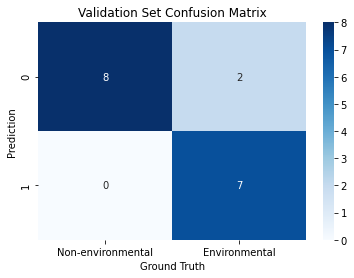

In [691]:
cm = confusion_matrix(y_val, yval_preds)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Non-environmental', 'Environmental'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction');
print('Recall:', recall_score(y_val, yval_preds))
print('Precision:', precision_score(y_val, yval_preds))

In [692]:
X_train.shape, X_test.shape

((71, 610), (28, 610))

In [693]:
test_preds = xgb.predict(X_test)
test_acc_xgb = (test_preds == y_test).sum().astype(float) / len(test_preds)*100
print("XGBoost's test prediction accuracy is: %3.2f" % (test_acc_xgb))

XGBoost's test prediction accuracy is: 92.86


In [694]:
pd.to_pickle(xgb, 'xgbclassifier.pkl')

### Extras

In [262]:
#No Kfold cross validation yet
def run_model_n_times(n_times):
    train_scores, test_scores = [], []
    
    runs = 0
    while runs < n_times:
        print(f'{runs+1} Run(s)')
        text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        #first model using TFIDF vectorizer
        X_train, X_test, df_train, df_test, vectorizer = vectorize(text_train, text_test, 'tfidf')
        X_train.shape, X_test.shape

        model = BernoulliNB()
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
        print('Train Score:', train_score)
        print('Test Score:', test_score)
        print('--------------------------')
        runs+=1
        
    print(f'Average Train Score ({n_times} Runs): {np.mean(train_scores)}')
    print(f'Average Test Score ({n_times} Runs): {np.mean(test_scores)}')

run_model_n_times(10)

1 Run(s)
Train Score: 0.8557692307692307
Test Score: 0.7714285714285715
--------------------------
2 Run(s)
Train Score: 0.8846153846153846
Test Score: 0.8
--------------------------
3 Run(s)
Train Score: 0.875
Test Score: 0.9428571428571428
--------------------------
4 Run(s)
Train Score: 0.75
Test Score: 0.6285714285714286
--------------------------
5 Run(s)
Train Score: 0.9326923076923077
Test Score: 0.9142857142857143
--------------------------
6 Run(s)
Train Score: 0.75
Test Score: 0.7142857142857143
--------------------------
7 Run(s)
Train Score: 0.8076923076923077
Test Score: 0.7428571428571429
--------------------------
8 Run(s)
Train Score: 0.7403846153846154
Test Score: 0.5714285714285714
--------------------------
9 Run(s)
Train Score: 0.8557692307692307
Test Score: 0.7428571428571429
--------------------------
10 Run(s)
Train Score: 0.8653846153846154
Test Score: 0.8857142857142857
--------------------------
Average Train Score (10 Runs): 0.8317307692307694
Average Test Sc

### Using CounterVectorizer

In [226]:
X_train, X_test, df_train, df_test, vectorizer = vectorize(text_train, text_test, 'counter')
X_train.shape, X_test.shape

((104, 475), (35, 475))

In [227]:
model = BernoulliNB()
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print('Train Score:', train_score)
print('Test Score:', test_score)

Train Score: 0.8173076923076923
Test Score: 0.7142857142857143


After trying out both TFIDF and Counter vectorizers, neither really have any discernable difference in performance.

In [493]:
from preprocessing import get_text_from_pdf, clean_text
file = 'Test Data/BILLS-116hr8915ih.pdf'
doc_str = get_text_from_pdf(file)
txt_cln = clean_text(doc_str)
txt_cln

'ith congressd session  h r to  amend  the  comprehensive  environmental  response  compensation  andliability  act  of    to  provide  for  the  consideration  of  climate  changeand for other purposesin  the  house  of  representativesdecember  mr  cleaver for  himself  and  ms  bass  introduced  the  following  bill  whichwas referred to the committee on energy and commerce and in additionto  the  committee  on  transportation  and  infrastructure  for  a  period  tobe  subsequently  determined  by  the  speaker  in  each  case  for  consideration  of  such  provisions  as  fall  within  the  jurisdiction  of  the  committeeconcerneda  billto amend the comprehensive environmental response compensation  and  liability  act  of    to  provide  for  theconsideration  of  climate  change  and  for  other  purposesbe  it  enacted  by  the  senate  and  house  of  representatives of the united states of america in congress assembledsection  short titlethis  act  may  be  cited  as  the  p

In [494]:
test_tfidf = vectorizer.transform([txt_cln])
model.predict(test_tfidf)[0]

True